# Evaluation Metrics for Long-Range Object Detection

Far away objects are prone to have less accurate predictions due to sparse point-clouds and increased LiDAR measurement uncertainty. Conventionally metrics like [NDS](https://github.com/nutonomy/nuscenes-devkit/blob/master/python-sdk/nuscenes/eval/detection/README.md) do not consider those aspects. Therefore, this notebook discusses the idea of using cosine similarity between the spherical coordinate representation of a bounding box center for the elevation and the azimuth angle and an L2 based loss for the radial distance of the object center. The weight of the loss of the objects shape is reduced with increasing distance. The loss function for an objects orientation is based on binning the heading in equivalently divided angle bins the number of which decreases with increasing distance of the object (inspired by [[1](https://openaccess.thecvf.com/content_cvpr_2018/papers/Qi_Frustum_PointNets_for_CVPR_2018_paper.pdf)]).

We express the loss function for the direction of the object in the following way:

$\mathcal{L}_{dir}(\textbf{x}^{(pred)}_{loc}, \textbf{x}^{(gt)}_{loc}) = \frac{\textbf{x}^{(pred)}_{loc} \cdot \textbf{x}^{(gt)}_{loc}}{\left\lVert\textbf{x}^{(pred)}_{loc}\right\lVert \left\lVert\textbf{x}^{(gt)}_{loc}\right\lVert}$

where $\textbf{x}^{(pred)}_{loc} \in \mathbb{R}^3$ is the prediction of the objects center location and $\textbf{x}^{(gt)}_{loc} \in \mathbb{R}^3$ is the ground truth of the objects center location.

The loss for the distance prediction is expressed in the following way:

$\mathcal{L}_{dist}(\textbf{x}^{(pred)}_{loc}, \textbf{x}^{(gt)}_{loc}) = \left|\left\lVert\textbf{x}^{(pred)}_{loc}\right\lVert - \left\lVert\textbf{x}^{(gt)}_{loc}\right\lVert\right|$

We can define some canonical loss for the shape of the object:

$\mathcal{L}_{shape}(\textbf{x}^{(pred)}, \textbf{x}^{(gt)}) = \left\lVert\textbf{x}^{(pred)}_{shape}- \textbf{x}^{(gt)}_{shape}\right\lVert$

with $\textbf{x}^{(pred)}_{shape}, \textbf{x}^{(gt)}_{shape} \in \mathbb{R}^3$. Importantly, the weight of this loss is antiproportional to the distance of the object.

Lastly, the loss for the orientation of the bounding box is defined as the correct prediction of the bin of the orientation.

$\mathcal{L}_{orient}(\textbf{x}^{(pred)}, \textbf{x}^{(gt)}) = 𝟙_{\mathcal{b}_{\left\Vert \textbf{x}^{(gt)}_{loc} \right\Vert}\left(\textbf{x}^{(pred)}\right) \equiv \mathcal{b}_{\left\Vert \textbf{x}^{(gt)}_{loc} \right\Vert}\left(\textbf{x}^{(gt)}\right)}$

where $\mathcal{b}(\cdot)$ determines the bin, which the orientation falls in. In our approach $\mathcal{b}(\cdot)_d$ is parameterized by a variable $d$, which is the distance of the bounding box. We loosen the requirement for accurate orientation prediction, by reducing the number of bins with increasing distance. In extreme cases, as little as 4 bins should be sufficient for far away objects.


In [4]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial.transform import Rotation

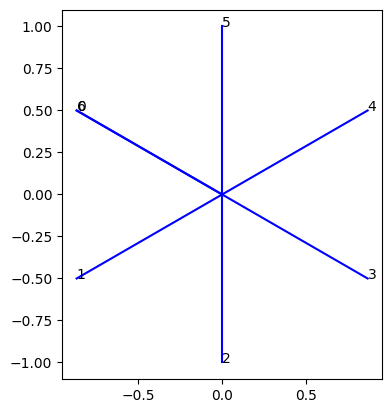

In [70]:
num_bins = 6
# we align the 
angle_heading_bins = np.linspace(
    (-1 - 1 / (num_bins)) * np.pi, (1 - 1 / (num_bins)) * np.pi, num_bins + 1
)

unit_x = np.array([1, 0, 0], dtype=float)
for i, angle in enumerate(angle_heading_bins):
    angle_boundary = Rotation.from_euler("xyz", [0, 0, angle]).apply(unit_x)
    plt.plot([0, angle_boundary[0]], [0, angle_boundary[1]], c="b")
    plt.text(angle_boundary[0], angle_boundary[1], str(i))
plt.gca().set_aspect("equal")

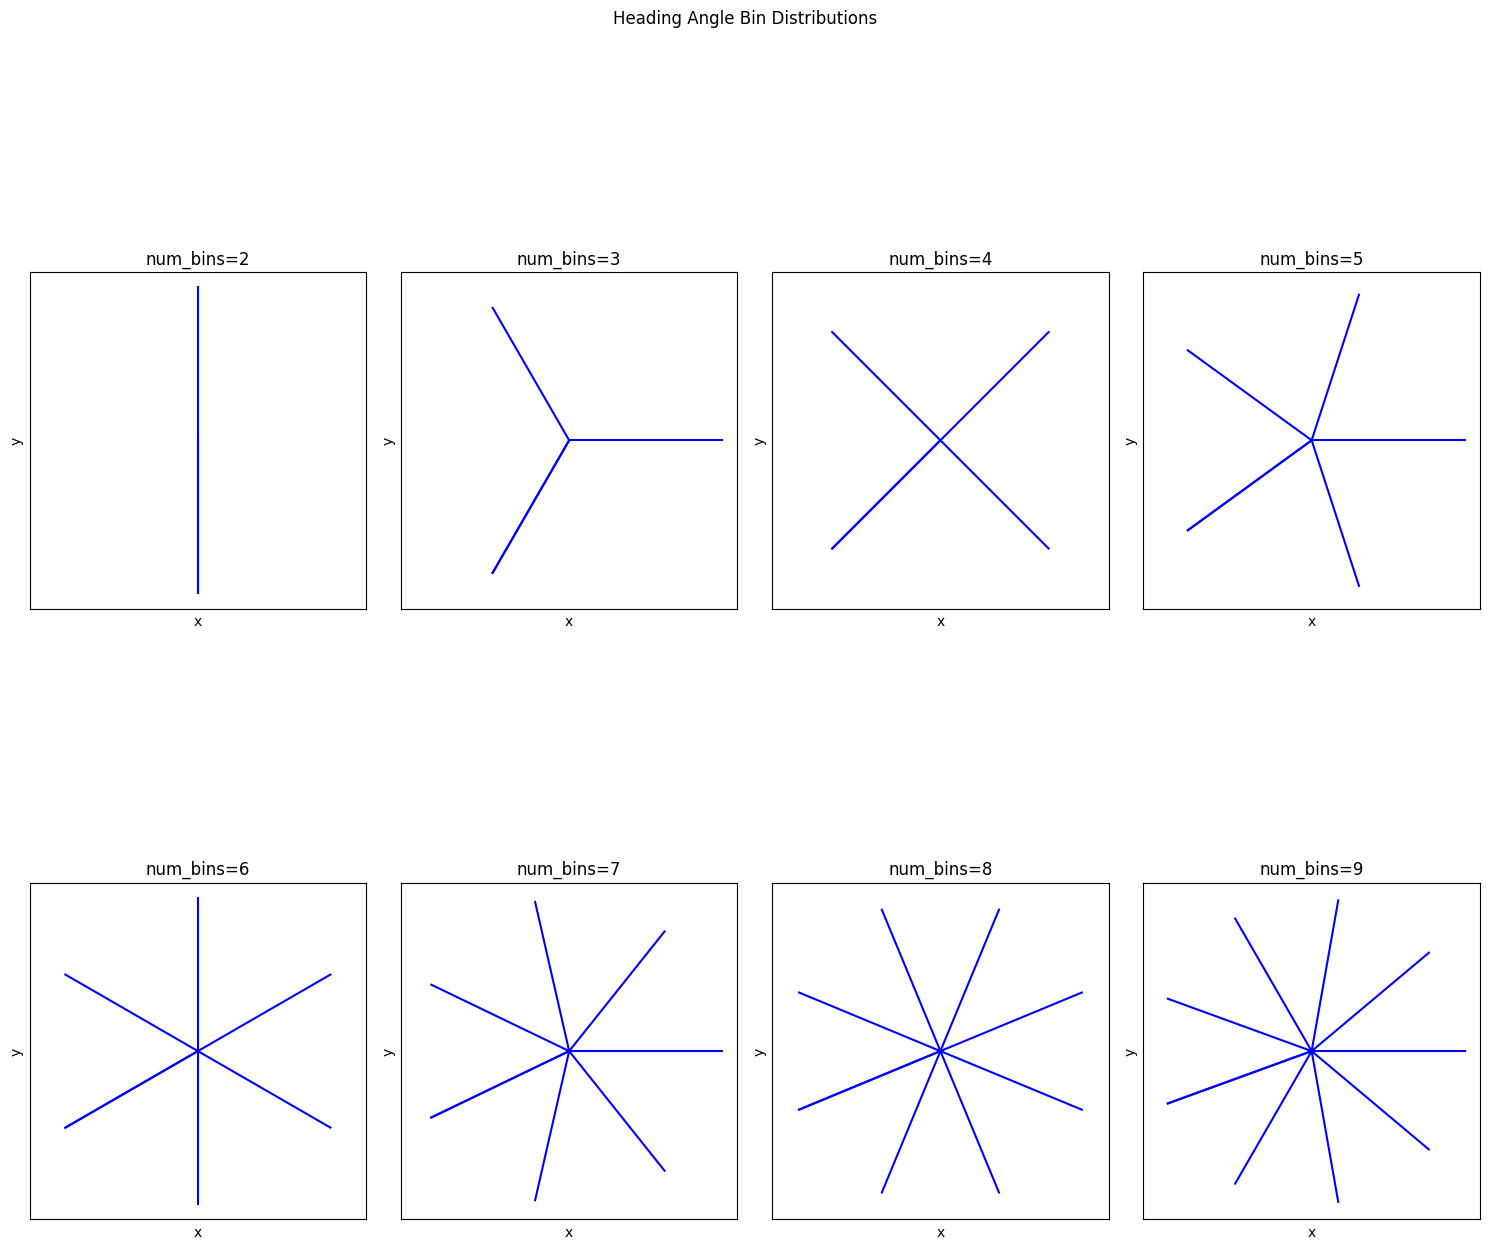

In [125]:
def plot_heading_bins(num_bins: int, ax):
    angle_heading_bins = np.linspace(
        -(1 - 1 / (num_bins)) * np.pi, (1 + 1 / (num_bins)) * np.pi, num_bins + 1
    )
    unit_x = np.array([1, 0, 0], dtype=float)
    for angle in angle_heading_bins:
        angle_boundary = Rotation.from_euler("xyz", [0, 0, angle]).apply(unit_x)
        ax.plot([0, angle_boundary[0]], [0, angle_boundary[1]], c='b')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_xlim((-1.1,1.1))
    ax.set_ylim((-1.1,1.1))
    ax.set_aspect('equal')
    ax.tick_params(
        axis='x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        labelbottom=False) # labels along the bottom edge are off
    ax.tick_params(
        axis='y',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        left=False,      # ticks along the bottom edge are off
        right=False,         # ticks along the top edge are off
        labelleft=False) # labels along the bottom edge are off


fig = plt.figure(figsize=(15,15))

fig.suptitle('Heading Angle Bin Distributions')
for num_bins in range(2, 10):
    ax = fig.add_subplot(2, 4, num_bins-1)
    ax.set_title(f"num_bins={num_bins}")
    plot_heading_bins(num_bins, ax)

plt.tight_layout()

In [98]:
# [tx, ty, tz, l, w, h, rz]
bounding_box = np.random.rand(7)
bounding_box[:3] -= 0.5
bounding_box[:3] *= 200
bounding_box[3] += 5
bounding_box[4] += 2
bounding_box[5] += 1.5
bounding_box[6] *= 2 * np.pi
bounding_box[6] -= np.pi
print(bounding_box)

[ 26.68125352  73.02191624 -52.95353156   5.70557576   2.38360802
   2.16498793   0.69503688]


In [50]:
def get_heading_angle_bin_count(distance, 
    max_bins: int = 20,
    min_bins: int = 3,
    max_distance: int = 200): 
    return int(max((max_distance - distance)/max_distance, 0) * (max_bins - min_bins) + min_bins)

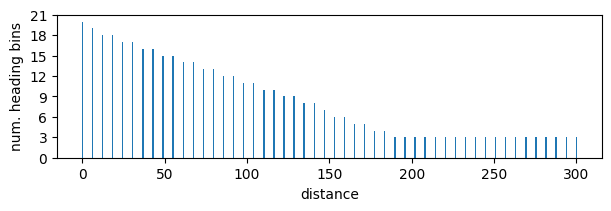

In [136]:
bin_count = list()
distances = np.linspace(0, 300)

fig, ax = plt.subplots(figsize=(6, 2), layout='constrained')
for distance in distances:
    bin_count.append(get_heading_angle_bin_count(distance))
ax.bar(distances, bin_count)
plt.ylabel('num. heading bins')
plt.xlabel('distance')

from matplotlib.ticker import MaxNLocator
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
